In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
from fastai.callbacks import *
import PIL
import cv2
import sklearn
import skimage
bs = 64

In [2]:
path_images = Path('/home/samudre/Music/1May/stage1')

In [3]:
data = ImageDataBunch.from_folder(path=path_images, train='train', valid='valid', bs=bs, classes=['garbage', 'nongb'])
data.normalize()

ImageDataBunch;

Train: LabelList (5512 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: /home/samudre/Music/1May/stage1;

Valid: LabelList (1376 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: /home/samudre/Music/1May/stage1;

Test: None

In [4]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 8.32E-03


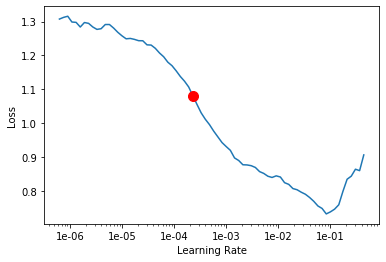

In [5]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [6]:
learn.fit_one_cycle(2, max_lr=slice(2e-4,4e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.546088,0.243336,0.090843,00:28
1,0.269112,0.179947,0.061047,00:27


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.91E-07


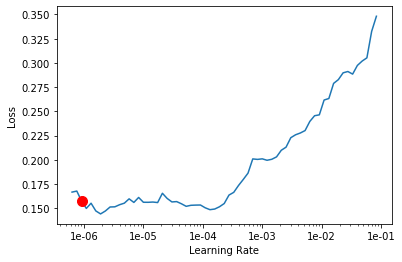

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.157729,0.162214,0.053052,00:36
1,0.113651,0.158672,0.057413,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.182952,0.283074,0.082849,00:36
1,0.190767,0.190277,0.082122,00:36
2,0.167676,0.189523,0.063227,00:36
3,0.112944,0.168069,0.050145,00:36
4,0.060351,0.177871,0.056686,00:36
5,0.025729,0.171935,0.049419,00:36


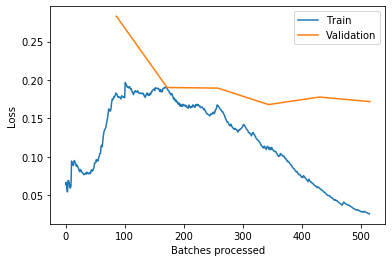

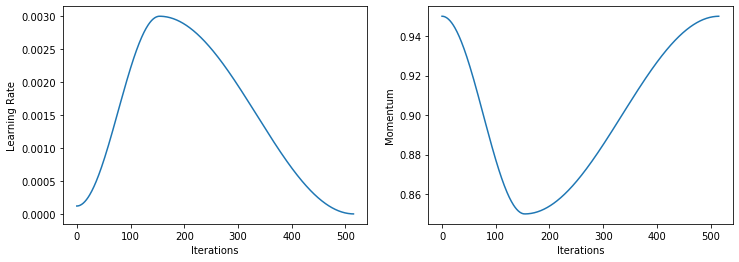

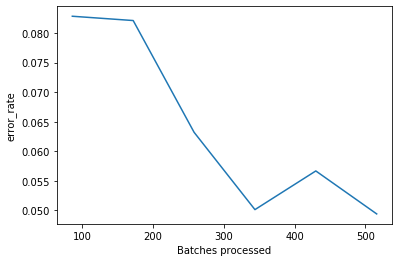

In [10]:
learn.fit_one_cycle(6)
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [11]:
learn.save('1may-GvsNG-r50')

In [12]:
learn.export('1may-GvsNG-r50.pkl')

In [ ]:
!ls '17Apr/stage1'

In [13]:
learn.load('1may-GvsNG-r50')

Learner(data=ImageDataBunch;

Train: LabelList (5512 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: /home/samudre/Music/1May/stage1;

Valid: LabelList (1376 items)
x: ImageList
Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620),Image (3, 31, 620)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: /home/samudre/Music/1May/stage1;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

In [14]:
interpret = ClassificationInterpretation.from_learner(learn)

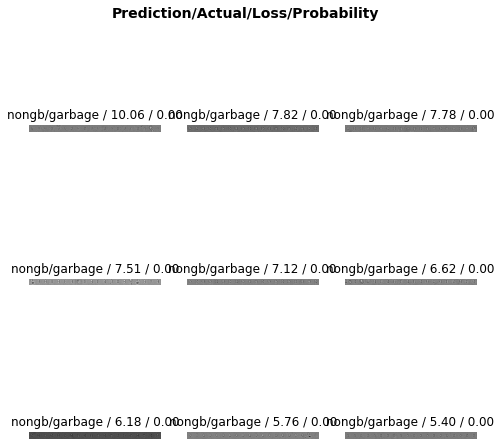

In [15]:
interpret.plot_top_losses(9, figsize=(8,8))

In [16]:
losses, indexes = interpret.top_losses(50)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

[PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BG1008_10s01_855.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BG1003_10s02_2706.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1003_10s01_1253.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1010_10s01_1008.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1017_10s03_858.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1017_10s01_1098.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BM1024_10s01_2528.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1003_10s02_2458.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BG1003_10s01_2429.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BG1003_10s02_1440.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/nongb/BK1003_10s02_142.jpg')
 PosixPath('/home/samudre/Music/1May/stage1/valid/garbage/BK1017_10s01_900.jpg')
 PosixPath('/home/samu

In [ ]:
###################  INTERNAL VALIDATION RESULTS  ##################

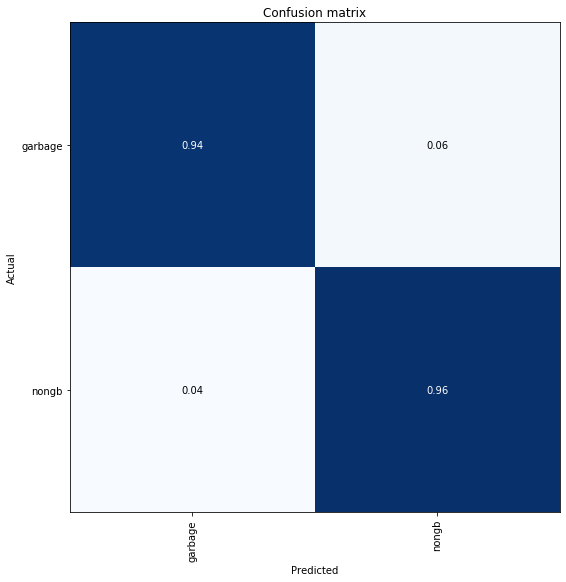

In [17]:
interpret.plot_confusion_matrix(normalize=True, figsize=(8,8))

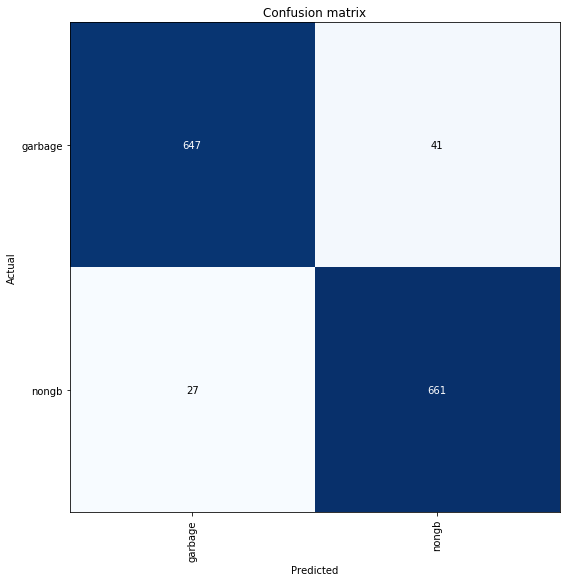

In [18]:
interpret.plot_confusion_matrix(figsize=(8,8))

In [ ]:
#################  VALIDATION (3 BK + 1 BG) ############### 

In [24]:
import glob
g1 = glob.glob('/home/samudre/Music/1May/validation/data-stage1/gb/*')
g2 = glob.glob('/home/samudre/Music/1May/validation/data-stage1/ngb/*')

TP_garbage = 0
gasng = 0
TP_ng = 0
ngasg = 0

validation_model = load_learner('/home/samudre/Music/1May/stage1/model', test=ImageList.from_folder('/home/samudre/Music/1May/validation'))
for each in g1:
    p,q,r = validation_model.predict(open_image(each))
    if str(p) == 'garbage':
        TP_garbage += 1
    else:
        gasng += 1
        
for each in g2:
    p,q,r = validation_model.predict(open_image(each))
    if str(p) == 'nongb':
        TP_ng += 1
    else:
        ngasg += 1

print('TP_garbage: ' + str(TP_garbage))
print('G-NonG: ' + str(gasng))
print('TP_nongarbage: ' + str(TP_ng))
print('NonG-G: ' + str(ngasg))

TP_garbage: 584
G-NonG: 48
TP_nongarbage: 601
NonG-G: 12
